# Coupling Overland FLow with Dorado for Particle Tracking after Wildfire

The Overland Flow Component is based on the initial notebook by Dr. Tian Gan

This project integrates the Overland Flow Simulation model from Landlab with the Dorado Particle Tracking Flow model. These two models, traditionally independent, have been coupled to track the flow of the particles during a rainfall event after a wildfire and determine how the area of the burnt land affect the pH of water at downstream. By combining the strengths of Overland Flow's hydrodynamic simulations and Dorado's particle tracking capabilities, we aim to provide a comprehensive tool for runoff generation and particle tracking.

<a id='setup'></a>
## Initial Setup


## Prepare the Input

### Install API key files
For the Topography and ERA5 data components, there is a need to create API key files to download the datasets. The install_api_key( ) function will ask for your [CDS API Key](https://cds.climate.copernicus.eu/api-how-to) and [Open Topography API Key](https://opentopography.org/blog/introducing-api-keys-access-opentopography-global-datasets) to create API key files. Please make sure you have already obtained those API Keys before you run this helper function.

In [1]:
from utils import install_api_key
install_api_key()

Enter Your OpenTopography API Key:  3342de98aec3c4295ed86fa3b7ec3218


OpenTopography API Key file is created at /home/jupyter-kmagno@stanford.ed-11250/.opentopography.txt.


Enter Your CDS API Key:  328580:6739e26f-8f5d-4d92-b9a3-063dbc6d0157


CDS API Key file is created at /home/jupyter-kmagno@stanford.ed-11250/.cdsapirc


### Create folders
We will first import all the python packages and then create three folders for this notebook:
- **configuration file folder**: this folder includes a configuration file which will be used by the data component. In this example, we have prepared a configuration file ('dem_config.yaml') and put it in this folder. 
- **cache folder**: this folder stores the downloaded data file.
- **results folder**: this folder stores the final results.

In [2]:
# import packages 
import os
import warnings

import numpy as np
import pandas as pd
import xarray
from datetime import datetime
import cftime
import matplotlib.pyplot as plt
from matplotlib import colors
import imageio.v2 as imageio
from IPython.display import Video
from tqdm import trange

from pymt.models import Topography, Era5
from landlab import RasterModelGrid, imshow_grid, imshow_grid_at_node
from landlab.components import FlowAccumulator, ChannelProfiler
from landlab.components.overland_flow import OverlandFlow
from landlab.plot.drainage_plot import drainage_plot
from landlab.utils import get_watershed_mask

warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams.update({'font.size': 14})

/opt/tljh/user/envs/csdms/lib/python3.11/site-packages/model_metadata/model_info.py:118: UserWarning: None: version string does not follow PEP440
  warnings.warn(f"{version}: version string does not follow PEP440")


In [3]:
# create folders
study_area = 'calwood'

config_dir = os.path.join(os.getcwd(), 'config_files_{}'.format(study_area))
results_dir = os.path.join(os.getcwd(), 'results_{}'.format(study_area)) 
cache_dir = os.path.join(os.getcwd(),'cache_{}'.format(study_area))


for folder in [config_dir, results_dir, cache_dir]:
    if not os.path.isdir(folder):
        os.mkdir(folder)
        print(folder)

<a id='step1'></a>
## Step 1 Download Dataset

### OpenTopography DEM 

The number of wildfire increased in the Colorado State in recent years. A destructive wildfire can burn away plants and trees that prevent erosion. If heavy rains occur after such a fire, landslides and flash floods can occur. In this example, we will simulate the overland flow for a study area in the northwest of Boulder which was impacted by the CalWood Fire occurred in 2020. 

We will use the [Topography data component](https://csdms.colorado.edu/wiki/Model:Topography_Data_Component) to download the Digital Elevation Model (DEM) data with 30m resolution. The 'dem_config.yaml' file includes the parameter settings of this data component. The following cells demonstrate how to use the configuration file to initialize a data component and how to use the variable and grid related methods of this data component to get the metadata as well as the data values.

In [4]:
# initialize Topography data component
dem = Topography()
dem.initialize(os.path.join(config_dir, 'dem_config.yaml'))

In [5]:
# get DEM variable info
var_name = dem.output_var_names[0]
var_unit = dem.var_units(var_name)
var_location = dem.var_location(var_name)
var_type = dem.var_type(var_name)
var_grid = dem.var_grid(var_name)
var_itemsize = dem.var_itemsize(var_name)
var_nbytes = dem.var_nbytes(var_name)
print('variable_name: {} \nvar_unit: {} \nvar_location: {} \nvar_type: {} \nvar_grid: {} \nvar_itemsize: {}' 
            '\nvar_nbytes: {} \n'. format(var_name, var_unit, var_location, var_type, var_grid, var_itemsize, var_nbytes))

variable_name: land_surface__elevation 
var_unit: degrees 
var_location: face 
var_type: int16 
var_grid: 0 
var_itemsize: 2
var_nbytes: 70468 



In [6]:
# get DEM grid info 
dem_grid_ndim = dem.grid_ndim(var_grid) 
dem_grid_type = dem.grid_type(var_grid)
dem_grid_shape = dem.grid_shape(var_grid)
dem_grid_spacing = dem.grid_spacing(var_grid)
dem_grid_origin = dem.grid_origin(var_grid)

print('grid_ndim: {} \ngrid_type: {} \ngrid_shape: {} \ngrid_spacing: {} \ngrid_origin: {}'.format(
    dem_grid_ndim, dem_grid_type, dem_grid_shape, dem_grid_spacing, dem_grid_origin))

grid_ndim: 2 
grid_type: uniform_rectilinear 
grid_shape: [158 223] 
grid_spacing: [0.00027778 0.00027778] 
grid_origin: [  40.13527778 -105.35305556]


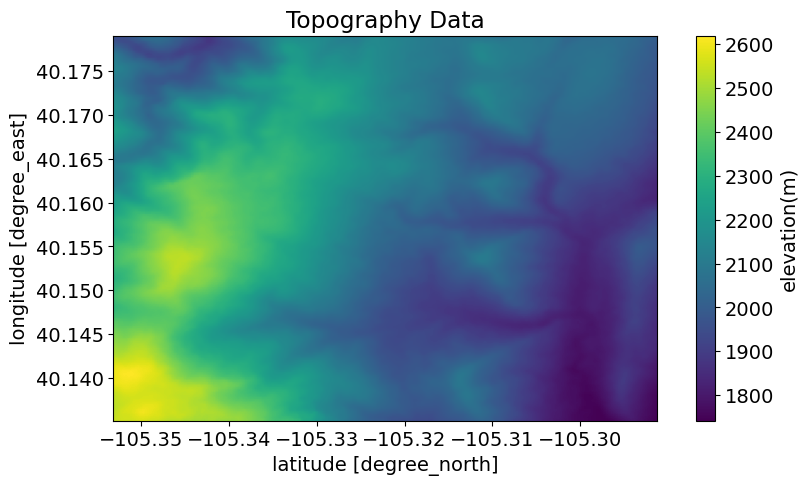

In [7]:
# get DEM variable data
dem_data = dem.get_value(var_name)
dem_data_2D = dem_data.reshape(dem_grid_shape)

# get X, Y extent for plot
min_y, min_x = dem_grid_origin
max_y = min_y + dem_grid_spacing[0]*(dem_grid_shape[0]-1)
max_x = min_x + dem_grid_spacing[1]*(dem_grid_shape[1]-1)
dy = dem_grid_spacing[0]/2
dx = dem_grid_spacing[1]/2
dem_extent = [min_x - dx, max_x + dx, min_y - dy, max_y + dy]

# plot DEM data
fig, ax = plt.subplots(1,1,figsize=(10,5))
im = ax.imshow(dem_data_2D, extent=dem_extent)
ax.title.set_text('Topography Data')
ax.set_xlabel('latitude [degree_north]')
ax.set_ylabel('longitude [degree_east]')
fig.colorbar(im,label='elevation(m)')

In [8]:
dem_data.shape


(35234,)

In [9]:
dem_data_2D.shape

(158, 223)

### ERA5 Precipitation
We will use the [ERA5 data component](https://csdms.colorado.edu/wiki/Model:ERA5_Data_Component) to download the hourly total precipitation data with 0.25 degrees (27-28km) resolution. The 'era5_config.yaml' file includes the parameter settings of this data component. The following cells demonstrate how to use the configuration file to initialize an ERA5 data component and how to use the variable, grid and time related methods to get the metadata as well as the data values. 

You'll notice that although the ERA5 and Topography data components download the datasets from different sources, they are using the same methods to get information from the datasets. Please note that sometimes the request for ERA5 data may be queued which may take a while (>10min) to get the data downloaded.

In [9]:
# subsitute with new precip data [revised by nikki]
# need revision of both yaml and nc file [revised by nikki]
# initialize ERA5 data component

era5 = Era5()
era5.initialize(os.path.join(config_dir,'era5_config.yaml'))

In [10]:
# get ERA5 variable info
var_name = era5.output_var_names[0]
var_unit = era5.var_units(var_name)
var_location = era5.var_location(var_name)
var_type = era5.var_type(var_name)
var_grid = era5.var_grid(var_name)
var_itemsize = era5.var_itemsize(var_name)
var_nbytes = era5.var_nbytes(var_name)
print('variable_name: {} \nvar_unit: {} \nvar_location: {} \nvar_type: {} \nvar_grid: {} \nvar_itemsize: {}' 
        '\nvar_nbytes: {} \n'. format(var_name, var_unit, var_location, var_type, var_grid, var_itemsize, var_nbytes))

variable_name: Total precipitation 
var_unit: m 
var_location: node 
var_type: float64 
var_grid: 0 
var_itemsize: 2
var_nbytes: 8 



In [11]:
# get ERA5 grid info
era5_grid_ndim = era5.grid_ndim(var_grid) 
era5_grid_type = era5.grid_type(var_grid)
era5_grid_shape = era5.grid_shape(var_grid)
era5_grid_spacing = era5.grid_spacing(var_grid)
era5_grid_origin = era5.grid_origin(var_grid)

print('grid_ndim: {} \ngrid_type: {} \ngrid_shape: {} \ngrid_spacing: {} \ngrid_origin: {}'.format(
    era5_grid_ndim, era5_grid_type, era5_grid_shape, era5_grid_spacing, era5_grid_origin))

grid_ndim: 2 
grid_type: uniform_rectilinear 
grid_shape: [2 2] 
grid_spacing: [0.25 0.25] 
grid_origin: [  40.13000107 -105.36000061]


In [12]:
# get ERA5 time info
era5_start_time = era5.start_time
era5_end_time = era5.end_time
era5_time_step = era5.time_step
era5_time_unit = era5.time_units
era5_time_steps = int((era5_end_time - era5_start_time)/era5_time_step) + 1

print('start_time:{} \nend_time:{} \ntime_step:{} \ntime_unit:{} \ntime_steps:{}'.format(
    era5_start_time, era5_end_time, era5_time_step, era5_time_unit, era5_time_steps))

start_time:1059024.0 
end_time:1059095.0 
time_step:1.0 
time_unit:hours since 1900-01-01 00:00:00.0 
time_steps:72


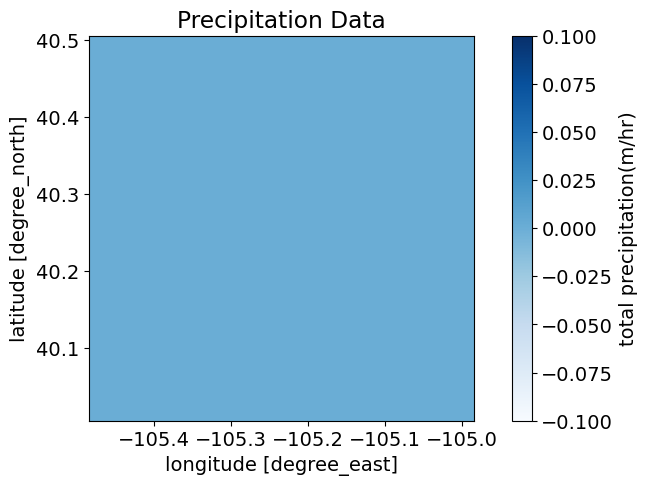

In [13]:
# get ERA5 variables data (at first time step)
era5_data = era5.get_value(var_name)
era5_data_2D = era5_data.reshape(era5_grid_shape)

# get X, Y extent for plot
min_y, min_x = era5_grid_origin
max_y = min_y + era5_grid_spacing[0]*(era5_grid_shape[0]-1)
max_x = min_x + era5_grid_spacing[1]*(era5_grid_shape[1]-1)
dy = era5_grid_spacing[0]/2
dx = era5_grid_spacing[1]/2
era5_extent = [min_x - dx, max_x + dx, min_y - dy, max_y + dy]

# plot 2D ERA5 data
fig, ax = plt.subplots(1,1,figsize=(10,5))
im = ax.imshow(era5_data_2D, extent=era5_extent, cmap='Blues')
ax.title.set_text('Precipitation Data'.format(var_unit))
ax.set_xlabel('longitude [degree_east]')
ax.set_ylabel('latitude [degree_north]')
fig.colorbar(im,label='total precipitation(m/hr)')

The plot above shows the hourly total precipitation on June 25, 2021 (for the first time step at 00:00). The use case study site (see details in [Step2](#step2)) locates within the area that is covered by the pixel at the bottom left. 

We also create a time series plot to show the ERA5 hourly total precipitation data for June 25. In the plot below, we could see that the maximum hourly total precipitation is around 2.6 mm. This is much smaller than the observational rain intensity data obtained from the local station on June 25, which are 59.2 mm/hr (15min  intensity), 29.6 mm/hr (30min intensity), and 14.8 mm/hr (60min intensity). The value discrepancy is mainly caused by the fact that the ERA5 dataset has 0.25 degrees resolution and the total precipitation is calculated based on a large area leading to a very small value. Thus, to better represent the rain intensity situation at the study site, we will use the observational data from the local station for the overland flow simulation.

In [14]:
# get ERA5 time series data
time_steps = 72 
prec_array = np.empty(time_steps)
cftime_array = np.empty(time_steps)

for i in range(0, time_steps):   
    prec_array[i] = era5.get_value(var_name)[2] * 1000  # unit conversion m to mm 
    cftime_array[i] = era5.time
    era5.update()

time_array = cftime.num2date(cftime_array, era5_time_unit, only_use_cftime_datetimes=False, only_use_python_datetimes=True)

<a id='step2'></a>
## Step 2 Delineate Watershed

We will use the topography data for watershed delineation. The Landlab components ([FlowAccumulator](https://landlab.readthedocs.io/en/master/reference/components/flow_accum.html) and [ChannelProfiler](https://landlab.readthedocs.io/en/master/reference/components/channel_profiler.html)) and the Landlab utility ([get_watershed_mask](https://landlab.readthedocs.io/en/master/reference/utils/watershed.html)) will be used to accomplish this task. The general steps for watershed delineation include: 
- Setup raster model grid and add topographic elevation data field
- Calculate the flow accumulation
- Get watershed mask
- Set watershed boundary 

Text(0, 0.5, 'north-south distance (m)')

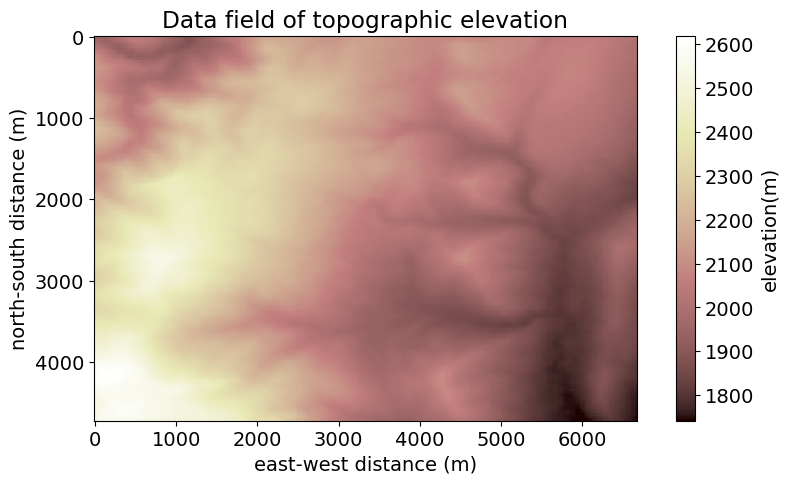

In [15]:
# set up raster model grid  
model_grid = RasterModelGrid(dem_grid_shape, xy_spacing=30)

# add topographic elevation data field
dem_field = model_grid.add_field("topographic__elevation", dem_data.astype('float'))

# plot the topographic elevation data field
plt.figure(figsize=(10,5))
ax = plt.gca()
ax.invert_yaxis()
imshow_grid(model_grid,
            'topographic__elevation',
            plot_name='Data field of topographic elevation',
            var_name='elevation(m)')
ax.set_xlabel('east-west distance (m)')
ax.set_ylabel('north-south distance (m)')


In [16]:
# calculate the flow accumulation
fa=FlowAccumulator( model_grid, method='Steepest', 
                    flow_director='FlowDirectorSteepest', 
                    depression_finder='LakeMapperBarnes',
                    redirect_flow_steepest_descent=True,
                    reaccumulate_flow=True)
fa.run_one_step()  

In [17]:
# set up channel profiler 
profiler = ChannelProfiler(model_grid,number_of_watersheds=1)
profiler.run_one_step()

In [21]:
# channelprofiler

In [18]:
# get watershed mask
outlet = profiler.nodes[0][0]
watershed_mask = get_watershed_mask(model_grid, outlet)

In [19]:
# set watershed boundary
model_grid.at_node["topographic__elevation"][~watershed_mask] = -9999.0
model_grid.status_at_node[~watershed_mask] = model_grid.BC_NODE_IS_CLOSED
model_grid.status_at_node[outlet] = model_grid.BC_NODE_IS_FIXED_VALUE

Text(0, 0.5, 'north-south distance (m)')

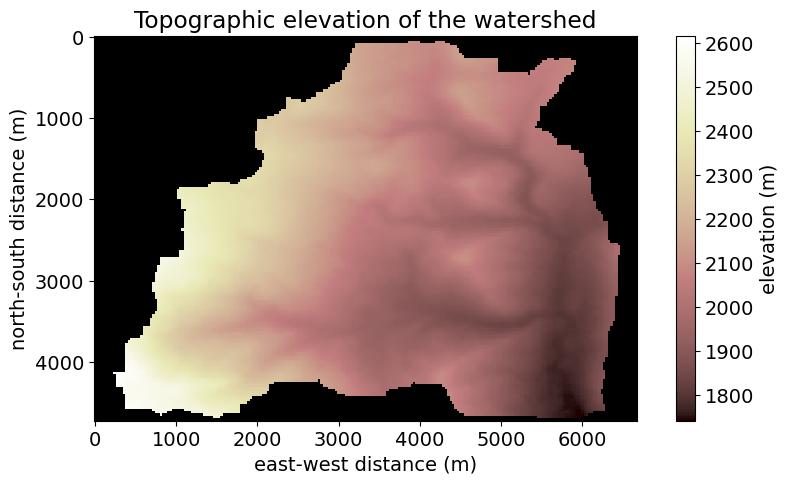

In [20]:
# plot the watershed 
plt.figure(figsize=(10,5))
ax = plt.gca()
ax.invert_yaxis()
imshow_grid_at_node(model_grid, dem_field, 
                    plot_name='Topographic elevation of the watershed',
                    colorbar_label="elevation (m)")

ax.set_xlabel('east-west distance (m)')
ax.set_ylabel('north-south distance (m)')

<a id='step3'></a>
## Step 3  Calculate Overland Flow

In this step, the topography elevation of the watershed and the [Overland Flow component](https://landlab.readthedocs.io/en/master/user_guide/overland_flow_user_guide.html#background-on-overlandflow-component) will be used for the simulation. The model run time is set as 200 min with the first 10 min assigned with a constant rainfall intensity (59.2 mm/hr), which is based on the observation on June 25, 2021 (the summer after the Calwood fire occured). 

In this simulation, we suppose there is no water infiltration process involved. Is this justified? Not really, this is a model simplification for demonstration purposes. But, wildfires cause soils to become extremely dry and  hydrophobic, and decrease infiltration. So this assumption provides an end-member case of extreme soil water repellency affecting the Geer Canyon watershed.

The simulation results will create a discharge time series plot at the outlet and 2D plots of the surface water depth at each 30 sec time step.

Text(0, 0.5, 'north-south distance (m)')

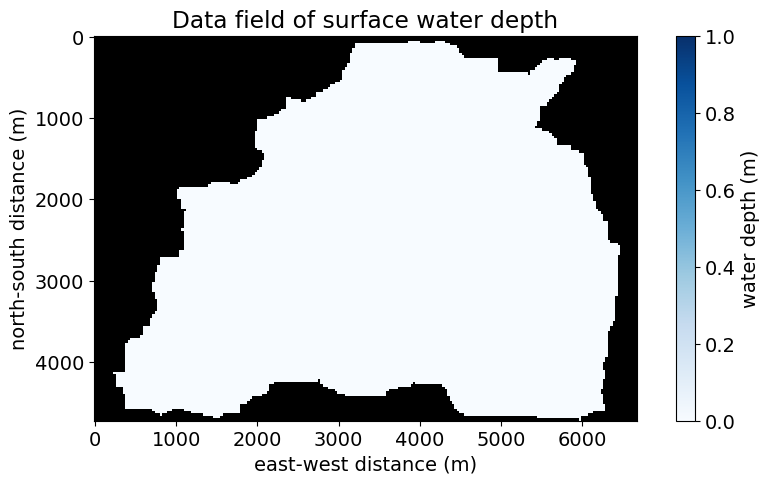

In [21]:
# add surface wate depth data field 
model_grid.add_zeros("surface_water__depth", at="node", clobber=True)

# set initial surface water depth value
model_grid.at_node["surface_water__depth"].fill(
    1e-12
) 

plt.figure(figsize=(10,5))
ax = plt.gca()
ax.invert_yaxis()
imshow_grid(model_grid,'surface_water__depth', 
            plot_name='Data field of surface water depth',
            var_name='water depth (m)',
            cmap="Blues", vmin=0.0,vmax=1)
ax.set_xlabel('east-west distance (m)')
ax.set_ylabel('north-south distance (m)')

For the input to the Dorado we need inputs: qx, qy, stage and depth. The overland flow simulation gives us the qx, qy, and depth, so we add the stage into the model here.

In [22]:
# adding stage into model [revised by nikki]

# instantiate overland flow component
overland_flow = OverlandFlow(
    model_grid, steep_slopes=True
)

# set model run parameters
elapsed_time = 0.0
model_run_time = 200 * 60  # duration of run (s) 
storm_duration = 10 * 60  # duration of rain (s)  
time_step = 120 
rainfall_intensity = 59.2 /(1000*3600)  # mm/hr to m/s

outlet_discharge = []
outlet_times = []

discharge_results = []
depth_results = []
stage_results = []

# run overland flow simulation
for time_slice in trange(time_step, model_run_time + time_step, time_step):

    while elapsed_time < time_slice:

        # get adaptive time step
        overland_flow.dt = min(overland_flow.calc_time_step(), time_step)

        # set rainfall intensity
        if elapsed_time < (storm_duration):
            overland_flow.rainfall_intensity = rainfall_intensity
        else:
            overland_flow.rainfall_intensity = 0.0

        # run model
        overland_flow.overland_flow(dt=overland_flow.dt)

        # update elapsed time
        elapsed_time += overland_flow.dt

        # get discharge result
        discharge = overland_flow.discharge_mapper(
            model_grid.at_link["surface_water__discharge"], convert_to_volume=True
        )

        outlet_discharge.append(discharge[outlet])
        outlet_times.append(elapsed_time)
        
        discharge_results.append(model_grid.at_link['surface_water__discharge'])
        depth_results.append(model_grid.at_node['surface_water__depth'])
       
        # Calculate stage results: depth + dem
        stage = model_grid.at_node['surface_water__depth'] + dem_data
        stage_results.append(stage)  

    # plot result
    fig, ax = plt.subplots(
        2, 1, figsize=(8, 9), gridspec_kw={"height_ratios": [1, 1.5]}
    )
    fig.suptitle("Results at {} min".format(time_slice / 60))

    ax[0].plot(outlet_times, outlet_discharge, "-")
    ax[0].set_xlabel("Time elapsed (s)")
    ax[0].set_ylabel("discharge (cms)")
    ax[0].set_title("Water discharge at the outlet")

    imshow_grid(
        model_grid,
        "surface_water__depth",
        cmap="Blues",
        vmin=0,
        vmax=1.2,
        var_name="surface water depth (m)",
    )
    ax[1].set_title("")
    ax[1].invert_yaxis()
    ax[1].set_xlabel('east-west distance (m)')
    ax[1].set_ylabel('north-south distance (m)')

    plt.close(fig)
    fig.savefig(os.path.join(results_dir, "flow_{}.png".format(time_slice)))
    
print('Simulation is done')

100%|██████████| 100/100 [00:40<00:00,  2.49it/s]

Simulation is done


The output from the overland flow simulation is a 1D array for the qx and qy component. For the Dorado, we need them in  2D form. So, here we reshape the 1D array for qx and qy to the 2D and store the time series results from the overland flow simulation. 

In [23]:
# Initialize lists to store reshaped data for each time step [revised by nikki]

qx = []
qy = []
depth_series = []
stage_series = []

# Iterate over each time step in the results
for time_step_index in range(len(discharge_results)):
    # Process discharge_results
    # Extract the discharge data for the current time step
    q = discharge_results[time_step_index]

    # Map discharge from links to nodes
    qx_nodes = model_grid.map_mean_of_horizontal_links_to_node(q)
    qy_nodes = model_grid.map_mean_of_vertical_links_to_node(q)

    # Reshape the node-based discharge data to 2D grid
    q_x_2d = np.reshape(qx_nodes, model_grid.shape)
    q_y_2d = np.reshape(qy_nodes, model_grid.shape)

    # Store the reshaped results for discharge
    qx.append(q_x_2d)
    qy.append(q_y_2d)

    # Process depth_results
    # Extract the depth data for the current time step
    depth_nodes = depth_results[time_step_index]

    # Reshape the node-based depth data to 2D grid
    depth_2d = np.reshape(depth_nodes, model_grid.shape)

    # Store the reshaped results for depth
    depth_series.append(depth_2d)

    # Process stage_results
    # Extract the stage data for the current time step
    stage_nodes = stage_results[time_step_index]

    # Reshape the node-based stage data to 2D grid
    stage_2d = np.reshape(stage_nodes, model_grid.shape)

    # Store the reshaped results for stage
    stage_series.append(stage_2d)

# Convert results to numpy arrays for easier manipulation and analysis
qx = np.array(qx)  # Shape: (time_steps, 158, 223)
qy = np.array(qy)  # Shape: (time_steps, 158, 223)
depth_series = np.array(depth_series)  # Shape: (time_steps, 158, 223)
stage_series = np.array(stage_series)  # Shape: (time_steps, 158, 223)

# Print the shapes to verify
print("Shape of qx:", qx.shape)  # Should output (1560, 158, 223)
print("Shape of qy:", qy.shape)  # Should output (1560, 158, 223)
print("Shape of depth_series:", depth_series.shape)  # Should output (1560, 158, 223)
print("Shape of stage_series:", stage_series.shape)  # Should output (1560, 158, 223)


Shape of qx: (1560, 158, 223)
Shape of qy: (1560, 158, 223)
Shape of depth_series: (1560, 158, 223)
Shape of stage_series: (1560, 158, 223)


The outut from the Overland FLow Simulation is exported as a netcdf file to input into the Dorado.

In [24]:
# writing output into netcdf file [revised by nikki]

import numpy as np
from netCDF4 import Dataset

# Define output file name
output_file = 'hydrodynamic_results.nc'

# Open a new NetCDF file for writing
with Dataset(output_file, 'w', format='NETCDF4') as nc_file:
    # Create dimensions
    nc_file.createDimension('time', qx.shape[0])  # Number of time steps
    nc_file.createDimension('x', qx.shape[2])     # Number of x nodes (158)
    nc_file.createDimension('y', qx.shape[1])     # Number of y nodes (223)

    # Create variables
    # time_var = nc_file.createVariable('time', 'f4', ('time',))
    # x_var = nc_file.createVariable('x', 'f4', ('x',))
    # y_var = nc_file.createVariable('y', 'f4', ('y',))
    qx_var = nc_file.createVariable('qx', 'f4', ('time', 'y', 'x'))
    qy_var = nc_file.createVariable('qy', 'f4', ('time', 'y', 'x'))
    depth_var = nc_file.createVariable('depth', 'f4', ('time', 'y', 'x'))
    stage_var = nc_file.createVariable('stage', 'f4', ('time', 'y', 'x'))

    # Optionally add units attributes
    # time_var.units = 'seconds since simulation start'
    # x_var.units = 'meters'
    # y_var.units = 'meters'
    qx_var.units = 'cubic meters per second per meter'  # Example unit
    qy_var.units = 'cubic meters per second per meter'  # Example unit
    depth_var.units = 'meters'
    stage_var.units = 'meters'

    # Write data to variables
    # time_var[:] = np.arange(qx.shape[0]) * 120  # Assuming time steps are 120 seconds apart
    # x_var[:] = np.arange(qx.shape[1])  # Replace with actual x coordinates if available
    # y_var[:] = np.arange(qx.shape[2])  # Replace with actual y coordinates if available
    qx_var[:, :, :] = qx
    qy_var[:, :, :] = qy
    depth_var[:, :, :] = depth_series
    stage_var[:, :, :] = stage_series

print(f"Data successfully written to {output_file}")


Data successfully written to hydrodynamic_results.nc


<a id='step4'></a>
## Step 4 Visualize Results

Run the cells below and it will show a short video. You will be able to see the changes of the surface water depth over the watershed and the discharge at the outlet over the simulation time. 

You can also reset the value of the "rain_intensity" variable using the ERA5 dataset (see the 2nd code cell in [Step3](#step3)). Then rerun Step3 and Step4 to create new results for comparison. 

In [25]:
# Make a short video
img_files = [os.path.join(results_dir, file) for file in os.listdir(results_dir) if '.png' in file]
img_files.sort(key=lambda x: os.path.getmtime(x))

with imageio.get_writer(os.path.join(results_dir,'overland_flow.mp4'), mode='I', fps=1,macro_block_size=None ) as writer:
    for f in img_files:
        im = imageio.imread(os.path.join(results_dir, f))
        writer.append_data(im)

writer.close()

[rawvideo @ 0x5566983c0240] Stream #0: not enough frames to estimate rate; consider increasing probesize


Now, we input the output from the Overland FLow Simulation and use it for simulating the particle flow using the Dorado. We define all the parameters for the input, the locations for initiating the seeds, and the number of particles.

Theta parameter not specified - using 1.0
Gamma parameter not specified - using 0.05
Diffusion coefficient not specified - using 0.2
minimum depth for wetness not defined - using 10 cm
Cell Types not specified - Estimating from depth
Using weighted random walk


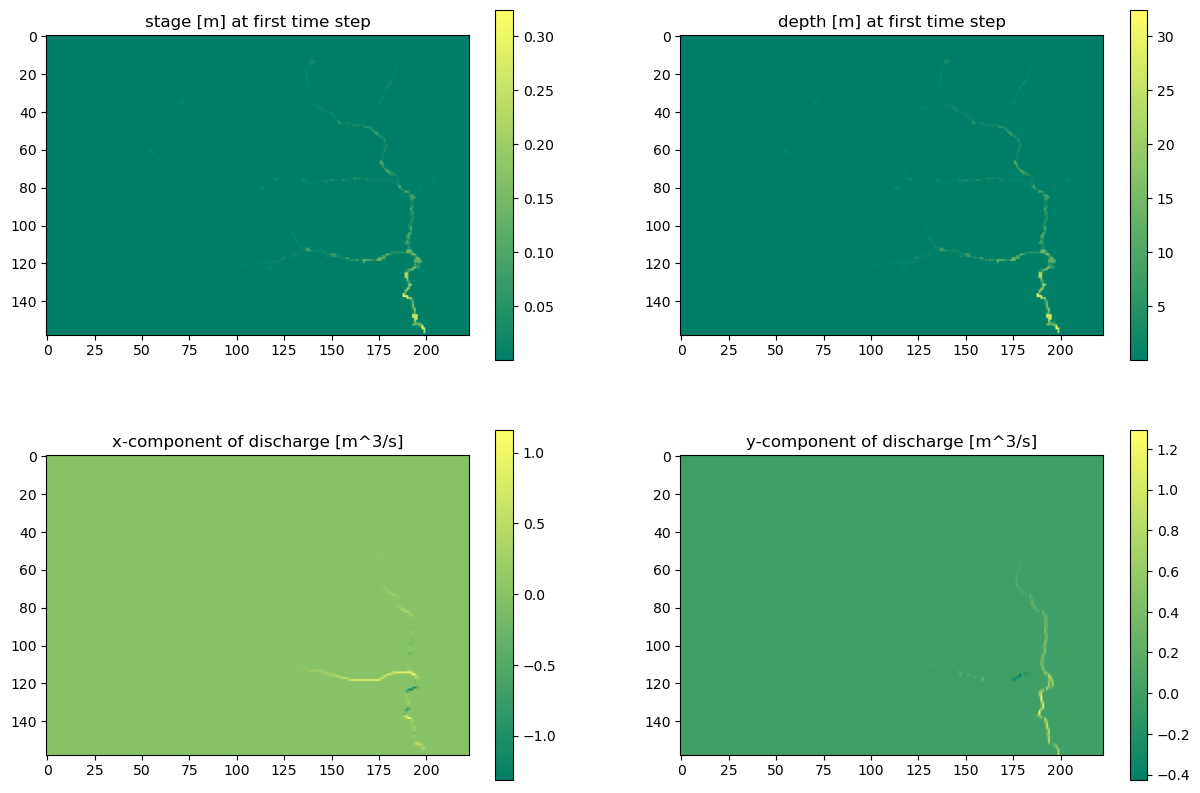

In [7]:
import numpy as np
import os
from dorado.routines import steady_plots
import dorado.particle_track as pt
from netCDF4 import Dataset
# libraries for loading our data
import pickle  # to access 'pickled' compressed data
import xarray as xr  # to load 'dimensional' data stored in netCDF files

# standard libraries for arrays and plots
import numpy as np  # base array manipulation library
import matplotlib.pyplot as plt  # standard plotting library

# library for particle simulation
import dorado
import pandas as pd 
from PIL import Image
import os
from PIL import Image
import math

# Load hydrodynamic results from the NetCDF file
nc_file = 'hydrodynamic_results.nc'
with Dataset(nc_file, 'r') as nc:
    qx = nc.variables['qx'][700]  
    qy = nc.variables['qy'][700]  
    depth = nc.variables['depth'][0]  


params = pt.modelParams()

# Define the params variables
params.stage = np.copy(depth)  
params.depth = depth*10
params.qx = qx
params.qy = qy
params.dx = 30.0  
params.model = 'Landlab'
particles = dorado.particle_track.Particles(params)  # supply model parameters)

# ## Make a bunch of plots
fig, ax = plt.subplots(2, 2, figsize=(15, 10))  # sets up a 2x2 set of axes

c1 = ax[0, 0].imshow(params.stage,cmap='summer')  # shows the stage grid
ax[0, 0].set_title('stage [m] at first time step')  # title for stage grid
fig.colorbar(c1, ax=ax[0, 0])

c2 = ax[0, 1].imshow(params.depth*10,cmap='summer')  # shows the depth grid
ax[0, 1].set_title('depth [m] at first time step')  # title for depth grid
fig.colorbar(c2, ax=ax[0, 1])

c3 = ax[1, 0].imshow(params.qx,cmap='summer')  # plots variable qx
ax[1, 0].set_title('x-component of discharge [m^3/s]')  # title
fig.colorbar(c3, ax=ax[1, 0])
             
c4 = ax[1, 1].imshow(params.qy,cmap='summer')  # plots variable qy
ax[1, 1].set_title('y-component of discharge [m^3/s]')  # title
fig.colorbar(c4, ax=ax[1, 1])

plt.show()  # displays the plots

Let's decide on the number of ash particles we want to place at the start of the stream. We assume each particle is equal to 0.5kg of ash. Enter in how many m^2 of burnt land we want to consider. We also assume 1m^2 of land = 1.6 kg/m^2 of ash [1].


1. Santín, C., Doerr, S. H., Otero, X. L., & Chafer, C. J. (2015). Quantity, composition and water contamination potential of ash produced under different wildfire severities. Environmental Research, 142, 297-308.

Enter Number of Acres of Wildfire Land:  50


Wildfire acreage: 50.0
160


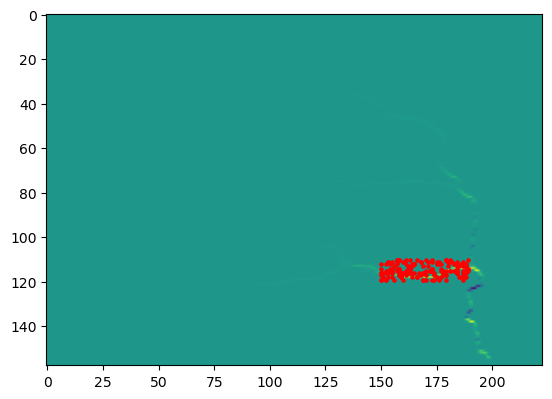

In [13]:
from get_float_input import wildfire_acres
a_f = wildfire_acres()
print(f"Wildfire acreage: {a_f}")
m_ash = a_f * 1.6
Np_tracer = round(m_ash/0.5)
print(Np_tracer)

# Initializing the particle location and the number of particles
seed_xloc = list(range(110, 120))  # x locations for seeding
seed_yloc = list(range(150, 190))  # y locations for seeding
# Apply the parameters to run the particle routing model
np.random.seed(0)  # Fix the random seed for reproducibility
# Initialize particles
particles.generate_particles(Np_tracer, seed_xloc, seed_yloc)

tt = 8*60*60  # 5 hours in seconds
walk_data = particles.run_iteration(target_time=tt)
wd = walk_data
DF = pd.DataFrame(wd)
dorado.routines.plot_state(params.qx, walk_data, iteration=0, c='r')
fnm = "walkdata.csv"
DF.to_csv(fnm)


In [41]:
len(depth)

158

In [43]:
plt.rcParams.update({'lines.markersize': 2})

frames = []
t_step = 15*60
frames_dir = 'frames'
for i in range(0, tt+t_step, t_step):
  dorado.routines.plot_state(
      params.stage, walk_data, target_time=i, c='r')
  plt.title(str(i/60/60) + ' hours')
  plt.grid(True)
  plt.xticks(np.arange(0, len(qx[0]), 10))
  plt.xticks(rotation=90)
  plt.yticks(np.arange(0, len(depth), 10))
  frame_filename = f'park_frame_{i:03d}.png'
  plt.savefig(frame_filename)
  plt.close()
  frames.append(Image.open(frame_filename))

Note: Particle 32 never reached target_time
Note: Particle 96 never reached target_time
Note: Particle 98 never reached target_time
Note: Particle 103 never reached target_time
Note: Particle 104 never reached target_time
Note: Particle 111 never reached target_time
Note: Particle 168 never reached target_time
Note: Particle 176 never reached target_time
Note: Particle 184 never reached target_time
Note: Particle 206 never reached target_time
Note: Particle 207 never reached target_time
Note: Particle 213 never reached target_time
Note: Particle 217 never reached target_time
Note: Particle 221 never reached target_time
Note: Particle 224 never reached target_time
Note: Particle 227 never reached target_time
Note: Particle 239 never reached target_time
Note: Particle 246 never reached target_time
Note: Particle 247 never reached target_time
Note: Particle 255 never reached target_time
Note: Particle 258 never reached target_time
Note: Particle 261 never reached target_time
Note: Particl

In [44]:
gif_filename = 'particle_flow.gif'
frames[0].save(gif_filename, save_all=True, append_images=frames[1:], duration=101, loop=10)

In [55]:
# count number of partical in target region
file_path = 'walkdata.csv'
data = pd.read_csv(file_path)
# Extract the last x and y coordinates for each particle
data['last_row'] = data['xinds'].apply(lambda x: int(x.strip('[]').split(',')[-1]))
data['last_col'] = data['yinds'].apply(lambda y: int(y.strip('[]').split(',')[-1]))
# Count the number of particles in the specified region
particles_in_region = data[(data['last_row'] >= 80) & (data['last_row'] <= 90) & (data['last_col'] <= 200) & (data['last_col'] >= 190)]
total_particle = len(particles_in_region)
print('Total Particles in Area = ')
print(total_particle)

Total Particles in Area = 
33


In [52]:
qx = params.qx
qy = params.qy

# Define the region of interest
x_min, x_max = 80, 90
y_min, y_max = 190, 200
qx_region = qx[x_min:x_max+1, y_min:y_max+1]
qy_region = qy[x_min:x_max+1, y_min:y_max+1]
magnitude = np.sqrt(qx_region**2 + qy_region**2)
avg_magnitude = np.mean(magnitude) * tt

Now, let's estimate the pH of the water downstream due to the KOH in the transported ash. A solution above 7 is basic.
References: 
2. Etiegni, L., & Campbell, A. G. (1991). Physical and chemical characteristics of wood ash. Bioresource technology, 37(2), 173-178.

In [54]:
# pH Calculation
# Define Area of Interest
# number of particles
m_ash = total_particle * 0.5
m_KC = 0.08 * m_ash # [2]
mol_KC = ((138.21e-3)/m_KC)**(-1)
mol_KOH = 2*mol_KC
M = (mol_KOH/(avg_magnitude*1e3))
pOH = (math.log(M,10))
pH = 14+pOH
print('pH = ')
print(pH)

pH = 
9.190999599773532


## References
- Adams, J. M., Gasparini, N. M., Hobley, D. E. J., Tucker, G. E., Hutton, E. W. H., Nudurupati, S. S., and Istanbulluoglu, E. (2017). The Landlab v1.0 OverlandFlow component: a Python tool for computing shallow-water flow across watersheds, Geoscientific Model Development, 10, 1645–1663, https://doi.org/10.5194/gmd-10-1645-2017.

- Barnhart, K. R., Hutton, E. W. H., Tucker, G. E., M. Gasparini, N., Istanbulluoglu, E., E. J. Hobley, D., J. Lyons, N., Mouchene, M., Siddhartha Nudurupati, S., M. Adams, J., & Bandaragoda, C. (2020). Short communication: Landlab v2.0: A software package for Earth surface dynamics. Earth Surface Dynamics, 8(2), 379–397. https://doi.org/10.5194/esurf-8-379-2020

- de Almeida, G. A., Bates, P., Freer, J. E., & Souvignet, M. (2012). Improving the stability of a simple formulation of the shallow water equations for 2‐D flood modeling. Water Resources Research, 48(5). https://doi.org/10.1029/2011WR011570

In [77]:
# q = model_grid.at_link["surface_water__discharge"]
# qx = model_grid.map_mean_of_horizontal_links_to_node(q)
# qy = model_grid.map_mean_of_vertical_links_to_node(q)
# q_x_2d = np.reshape(qx, model_grid.shape)
# q_X_2d.shape

# imshow_grid(model_grid, depth)

# d = model_grid.at_link["surface_water__depth"]
# depth = model_grid.map_mean_of_vertical_links_to_node(d)
# qx.size

# imshow_grid(model_grid, depth)